### Retrieving Data of Specific Conductivity for Coal Creek

In [1]:
#retrieving Specific Conductivity data for Coal Creek
import numpy as np
from dataretrieval import nwis
from matplotlib import pyplot as plt

# Inputs for site, variable, and date range
site = '09111250'  # for Coal Creek
pcode = '00095'    # for specific conductivity
startdate = '1990-01-01'
enddate = '2024-01-16'

# Retrieve data 
SC = nwis.get_qwdata(sites=site,
                 parameterCd=pcode,
                 startDt=startdate,
                 endDt=enddate)

C:\Users\jihad\anaconda3\lib\site-packages\dataretrieval\nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


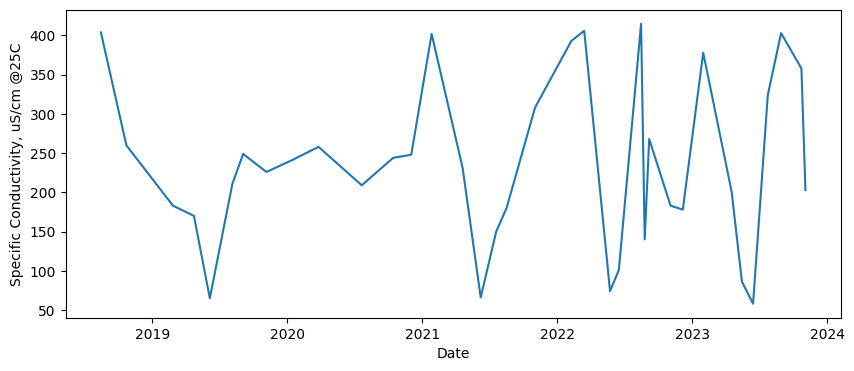

In [2]:
#SF[0]['00060'].replace(-999999, np.nan, inplace=True)
# Plot a time series of the Specific Conductivity
plt.figure(figsize=(10, 4))
plt.plot(SC[0]['p00095'])
plt.ylabel('Specific Conductivity, uS/cm @25C')
plt.xlabel('Date')
plt.show()

### Retrieving Data of Streamflow for Coal Creek

In [3]:
#plotting streamflow data

# Import libraries
from dataretrieval import nwis
from matplotlib import pyplot as plt

# Inputs for site, variable, and date range
site = '09111250'  # for Coal Creek
pcode = '00060'
#pcode = '00096'
startdate = '1990-01-01'
enddate = '2024-01-01'

# Retrieve data 

SF = nwis.get_iv(sites=site,
                 parameterCd=pcode,
                 startDt=startdate,
                 endDt=enddate)

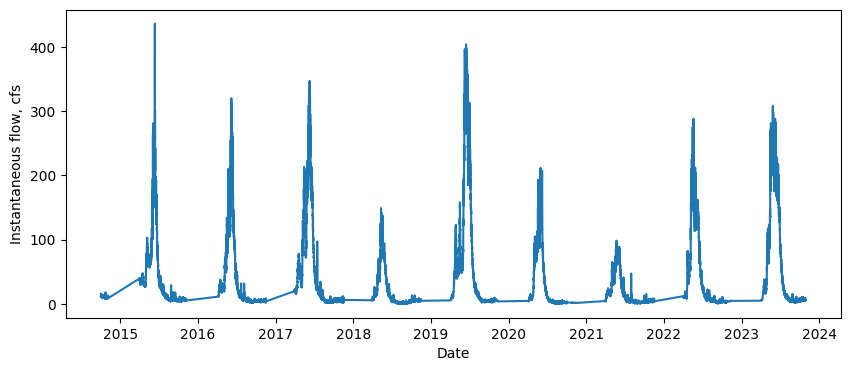

In [4]:
SF[0]['00060'].replace(-999999, np.nan, inplace=True)
# Plot a time series of the instantaneous flow
plt.figure(figsize=(10, 4))
plt.plot(SF[0]['00060'])
plt.ylabel('Instantaneous flow, cfs')
plt.xlabel('Date')
plt.show()

### Retrieve Basin

In [5]:
import pandas as pd
import pynhd as nhd
from pynhd import NLDI, NHDPlusHR, WaterData


In [6]:

station_id = "09111250"
# station_id = "09111250"

# Initialize the NLDI retrieval tool
nldi = NLDI()

# Find the basin upstream of the station
basin = nldi.get_basins(station_id)

# Find the main flow line
main_flow = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines",
    distance=1000)

tributary_flow = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="flowlines",
    distance=1000)

all_stations = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="nwissite",
    distance=1000)

# pour_points = nldi.navigate_byid(
#     fsource="nwissite",
#     fid=f"USGS-{station_id}",
#     navigation="upstreamTributaries",
#     source="huc12pp",
#     distance=1000)

# nmwdi = nldi.navigate_byid(
#     fsource="nwissite",
#     fid=f"USGS-{station_id}",
#     navigation="upstreamTributaries",
#     source="nmwdi-st",
#     distance=1000)

In [7]:
## Combine data
main_flow['type'] = 'main'
tributary_flow['type'] = 'tributary'
all_stations['type'] = 'station'
# pour_points['type'] = 'pourpoint'
# nmwdi['type'] = 'nmwdi'
basin['type'] = 'basin'

basin['description'] = 'Basin boundary.'
main_flow['description'] = f'The mainflow river upstream of USGS-{station_id}'
tributary_flow['description'] = f'Tributary river flows upstream of USGS-{station_id}'
all_stations['description'] = " "
# pour_points['description'] = f'HUC12 Pour Point'
# nmwdi['description'] = 'New Mexico Water Data Initiative Site <br>Water quality well.'

for i in all_stations.index:
    all_stations.loc[i, 'description'] = f'{all_stations.loc[i, "identifier"]} <br>Name: {all_stations.loc[i, "name"]}'

keep_columns = ['geometry', 'type', 'description']

# all_data = pd.concat([basin[keep_columns], 
#                       main_flow[keep_columns],
#                       tributary_flow[keep_columns],
#                       all_stations[keep_columns],
#                       pour_points[keep_columns],
#                       nmwdi[keep_columns]
#                       ]).reset_index(drop=True)
all_data = pd.concat([basin[keep_columns], 
                      main_flow[keep_columns],
                      tributary_flow[keep_columns],
                      all_stations[keep_columns],
                      ]).reset_index(drop=True)

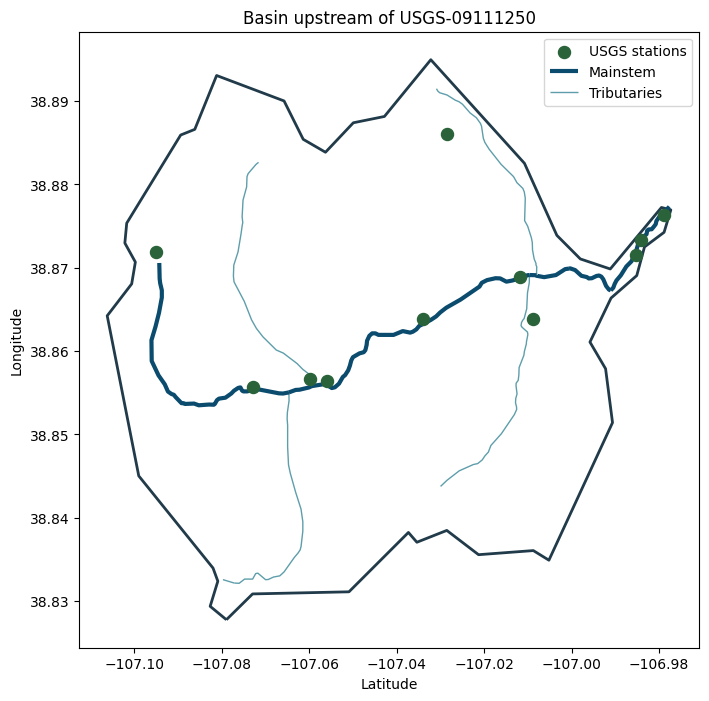

In [8]:
## Visualize basin features

# Line colors
basin_color, mainstem_color, tributary_color = ['#213b4a', '#0a4b6e', '#5e9eab']
 
# Point colors
usgs_color, nmwdi_color, pourpoint_color = ['#2a6339' , '#70207a', '#8f5e1a']

# Plot all features
ax = basin.plot(facecolor="none", edgecolor=basin_color, lw = 2, figsize=(8, 8))
all_stations.plot(ax=ax, label="USGS stations", marker="o", markersize=75, zorder=4, color= usgs_color)
# nmwdi.plot(ax=ax, label = 'NMWDI Sites', marker = "o", markersize = 50, color = nmwdi_color, zorder = 5)
# pour_points.plot(ax=ax, label="HUC12 pour points", marker="o", markersize=50, color=pourpoint_color, zorder=3)
main_flow.plot(ax=ax, lw=3, color=mainstem_color, zorder=2, label="Mainstem")
tributary_flow.plot(ax=ax, lw=1, zorder=1, color = tributary_color, label="Tributaries")
ax.legend(loc="best")

ax.set_aspect("auto")
ax.figure.set_dpi(100)
ax.set_title(f'Basin upstream of USGS-{station_id}')
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.figure.savefig("static_map.png", bbox_inches="tight", dpi=100)
ax
fig = ax.get_figure()
fig.savefig('blacksmithfork.png', dpi=400)

In [9]:
all_data.to_csv('basin_data.csv', sep = ',')

### create an interactive map

In [10]:
# Import packages
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely import wkt

# Specify the coordinate reference system (CRS)
crs = 4386

In [11]:
# Load the basin data
basin_data = pd.read_csv("basin_data.csv", sep = ',', index_col=0)

# Convert to a geoDataFrame and geometry objects
basin_data['geometry'] = basin_data['geometry'].apply(wkt.loads)
geodata = gpd.GeoDataFrame(basin_data, crs = crs)
geodata.head(2)

,geometry,type,description
0,"POLYGON ((-107.07891 38.82778, -107.08262 38.8...",basin,Basin boundary.
1,"LINESTRING (-106.99106 38.86729, -106.99047 38...",main,The mainflow river upstream of USGS-09111250


In [12]:
## Plot options
# Line widths
basin_linewidth = 2
mainstem_linewidth = 3
tributary_linewidth = 1

# Line colors
mainstem_color = '#0a4b6e'
tributary_color = '#5e9eab'
basin_color = '#213b4a'

# Point colors
usgs_color = '#2a6339'
# nmwdi_color = '#70207a'
pourpoint_color = '#8f5e1a'

# Point sizes
usgs_size = 10
# nmwdi_size = 10
pourpoint_size = 5

# Other options
fill_opacity = 0.85
popup_width = 300

# Combine options into a dictionary
plot_options = {
    'station':{'color': usgs_color,
               'size': usgs_size},
    'pourpoint': {'color': pourpoint_color,
                  'size': pourpoint_size},
    # 'nmwdi': {'color': nmwdi_color, 
    #           'size': nmwdi_size}
    }

In [13]:
# Initialize the map
start_coords = [39, -107.18]  
geomap = folium.Map(location = start_coords, 
                    zoom_start = 9.2,
                    tiles = 'cartodbpositron',
                    control_scale = True)

## Add different tiles (base maps)
folium.TileLayer('openstreetmap').add_to(geomap)
folium.TileLayer('stamenwatercolor').add_to(geomap)
folium.TileLayer('stamenterrain').add_to(geomap)


In [14]:
# Start feature groups for toggle functionality
basin_layer = folium.FeatureGroup(name = 'Basin Boundary', show=True)
usgs_layer = folium.FeatureGroup(name = 'USGS Gauges', show=True)
mainstem_layer = folium.FeatureGroup(name = 'Mainstem River', show=True)
tributary_layer = folium.FeatureGroup(name='Tributary Rivers', show=False)
pourpoint_layer = folium.FeatureGroup(name= 'HUC12 Pour Points', show=False)
# nmwdi_layer = folium.FeatureGroup(name='NM Water Data Initiative Gauge', show=True)

In [15]:
## Plotting Polygons and Lines

# Plot basin border
for i,r in geodata.loc[geodata['type'] == 'basin'].iterrows():
    # Convert the Polygon or LineString to geoJSON format
    geo_json = gpd.GeoSeries(r['geometry']).simplify(tolerance = 0.000001).to_json()
    geo_json = folium.GeoJson(data= geo_json,
                              style_function=lambda x: {'fillcolor': 'none',
                                                        'weight': basin_linewidth, 
                                                        'color': basin_color,
                                                        'opacity': 1,
                                                        'fill_opacity': 1,
                                                        'fill': False})
    # Add popup with line description
    folium.Popup(r.description,
                 min_width = popup_width,
                 max_width= popup_width).add_to(geo_json)
    
    # Add the feature to the appropriate layer
    geo_json.add_to(basin_layer)
    
# Add mainstem flowlines
for i,r in geodata.loc[geodata['type'] == 'main'].iterrows():
    
    geo_json = gpd.GeoSeries(r['geometry']).simplify(tolerance = 0.000001).to_json()
    geo_json = folium.GeoJson(data= geo_json,
                              style_function=lambda x: {'fillcolor': 'none',
                                                        'weight': mainstem_linewidth, 
                                                        'color': mainstem_color,
                                                        'opacity': 1,
                                                        'fill_opacity': 1,
                                                        'fill': False})
    folium.Popup(r.description,
                min_width = popup_width,
                max_width= popup_width).add_to(geo_json)
    geo_json.add_to(mainstem_layer)
    
    
# Add tributary flow lines
for i,r in geodata.loc[geodata['type'] == 'tributary'].iterrows():
    
    geo_json = gpd.GeoSeries(r['geometry']).simplify(tolerance = 0.000001).to_json()
    geo_json = folium.GeoJson(data= geo_json,
                              style_function=lambda x: {'fillcolor': 'none',
                                                        'weight': tributary_linewidth, 
                                                        'color': tributary_color,
                                                        'opacity': 1,
                                                        'fill_opacity': 1,
                                                        'fill': False})
    folium.Popup(r.description,
                min_width = popup_width,
                max_width= popup_width).add_to(geo_json)
    geo_json.add_to(tributary_layer)

In [16]:
## Plotting point data

plot_types = ['station', 'pourpoint']
plot_layers = [usgs_layer, pourpoint_layer]

for i, feature_type in enumerate(plot_types):

    map_layer = plot_layers[i]
    
    for _, point in geodata.loc[geodata['type'] == feature_type].iterrows():
        
        coords = [point.geometry.y, point.geometry.x]
        
        textbox = folium.Popup(point.description,
                               min_width= popup_width,
                               max_width= popup_width)
 
        folium.CircleMarker(coords,
                            popup= textbox,
                            fill_color = plot_options[feature_type]['color'],
                            fill = True,
                            fill_opacity = fill_opacity,
                            radius= plot_options[feature_type]['size'],
                            color = plot_options[feature_type]['color']).add_to(map_layer)
 


In [17]:
# Add all feature layers to the map
basin_layer.add_to(geomap)
usgs_layer.add_to(geomap)
mainstem_layer.add_to(geomap)
tributary_layer.add_to(geomap)
pourpoint_layer.add_to(geomap)
# nmwdi_layer.add_to(geomap)

# Add the toggle option for layers
folium.LayerControl().add_to(geomap)

In [18]:
# Save and view the map
geomap.save("BSF_basin_map.html")
geomap